# **Tomato Leaf Disease Classification using CNN**

This notebook focuses on the classification of tomato leaf diseases using Convolutional Neural Networks (CNN). The dataset used for this project is obtained from [Kaggle](https://www.kaggle.com/datasets/arjuntejaswi/plant-village). It consists of images of tomato leaves affected by various diseases, making it suitable for training a CNN model to classify these diseases.



# Fetching the Dataset

In [65]:
!pip install -q opendatasets

In [66]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/arjuntejaswi/plant-village/')

Skipping, found downloaded files in "./plant-village" (use force=True to force download)


In [67]:
!rm -r plant-village/PlantVillage/Pepper__bell___Bacterial_spot
!rm -r plant-village/PlantVillage/Pepper__bell___healthy
!rm -r plant-village/PlantVillage/Potato___healthy
!rm -r plant-village/PlantVillage/Potato___Late_blight
!rm -r plant-village/PlantVillage/Potato___Early_blight
!mv plant-village/PlantVillage/Tomato_Bacterial_spot plant-village/PlantVillage/Bacterial_Spot
!mv plant-village/PlantVillage/Tomato_Early_blight plant-village/PlantVillage/Early_Blight
!mv plant-village/PlantVillage/Tomato_Late_blight plant-village/PlantVillage/Late_Blight
!mv plant-village/PlantVillage/Tomato_Leaf_Mold plant-village/PlantVillage/Leaf_Mold
!mv plant-village/PlantVillage/Tomato_Septoria_leaf_spot plant-village/PlantVillage/Septoria_Leaf_Spot
!mv plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite plant-village/PlantVillage/Spider_Mite
!mv plant-village/PlantVillage/Tomato__Target_Spot plant-village/PlantVillage/Target_Spot
!mv plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus plant-village/PlantVillage/Yellow_Leaf_Curl_Virus
!mv plant-village/PlantVillage/Tomato__Tomato_mosaic_virus plant-village/PlantVillage/Mosaic_Virus
!mv plant-village/PlantVillage/Tomato_healthy plant-village/PlantVillage/Healthy

rm: cannot remove 'plant-village/PlantVillage/Pepper__bell___Bacterial_spot': No such file or directory
rm: cannot remove 'plant-village/PlantVillage/Pepper__bell___healthy': No such file or directory
rm: cannot remove 'plant-village/PlantVillage/Potato___healthy': No such file or directory
rm: cannot remove 'plant-village/PlantVillage/Potato___Late_blight': No such file or directory
rm: cannot remove 'plant-village/PlantVillage/Potato___Early_blight': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Bacterial_spot': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Early_blight': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Late_blight': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Leaf_Mold': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Septoria_leaf_spot': No such file or directory
mv: cannot stat 'plant-village/PlantVillage/Tomato_Sp

# Importing Dependencies

In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Constants

In [69]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
PATH = 'plant-village/PlantVillage'

# Importing data into a TensorFlow dataset object

We will use the `image_dataset_from_directory` API to load all images into a TensorFlow dataset. [Link to the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [70]:
dataset = image_dataset_from_directory(
    PATH,
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [71]:
class_names = dataset.class_names
class_names

['Bacterial_Spot',
 'Early_Blight',
 'Healthy',
 'Late_Blight',
 'Leaf_Mold',
 'Mosaic_Virus',
 'Septoria_Leaf_Spot',
 'Spider_Mite',
 'Target_Spot',
 'Yellow_Leaf_Curl_Virus']

In the cell below, it is evident that each batch contains 32 images, each with a resolution of 256x256 pixels. These images are represented in the RGB color channel.

In [72]:
for batch_images, batch_labels in dataset.take(1):
  print(batch_images.shape)
  print(batch_labels.numpy())

(64, 256, 256, 3)
[3 9 7 9 6 3 5 9 2 9 9 8 8 2 1 6 0 7 0 3 7 6 7 8 1 1 9 6 6 9 9 5 0 4 9 7 0
 9 6 6 2 3 6 2 3 3 7 8 6 3 6 7 7 5 7 3 3 8 6 7 2 7 6 4]


In [73]:
a = np.array([0.1, 0.2, 0.3])
a = a.astype("uint8")

# Visualizing the first batch of images.

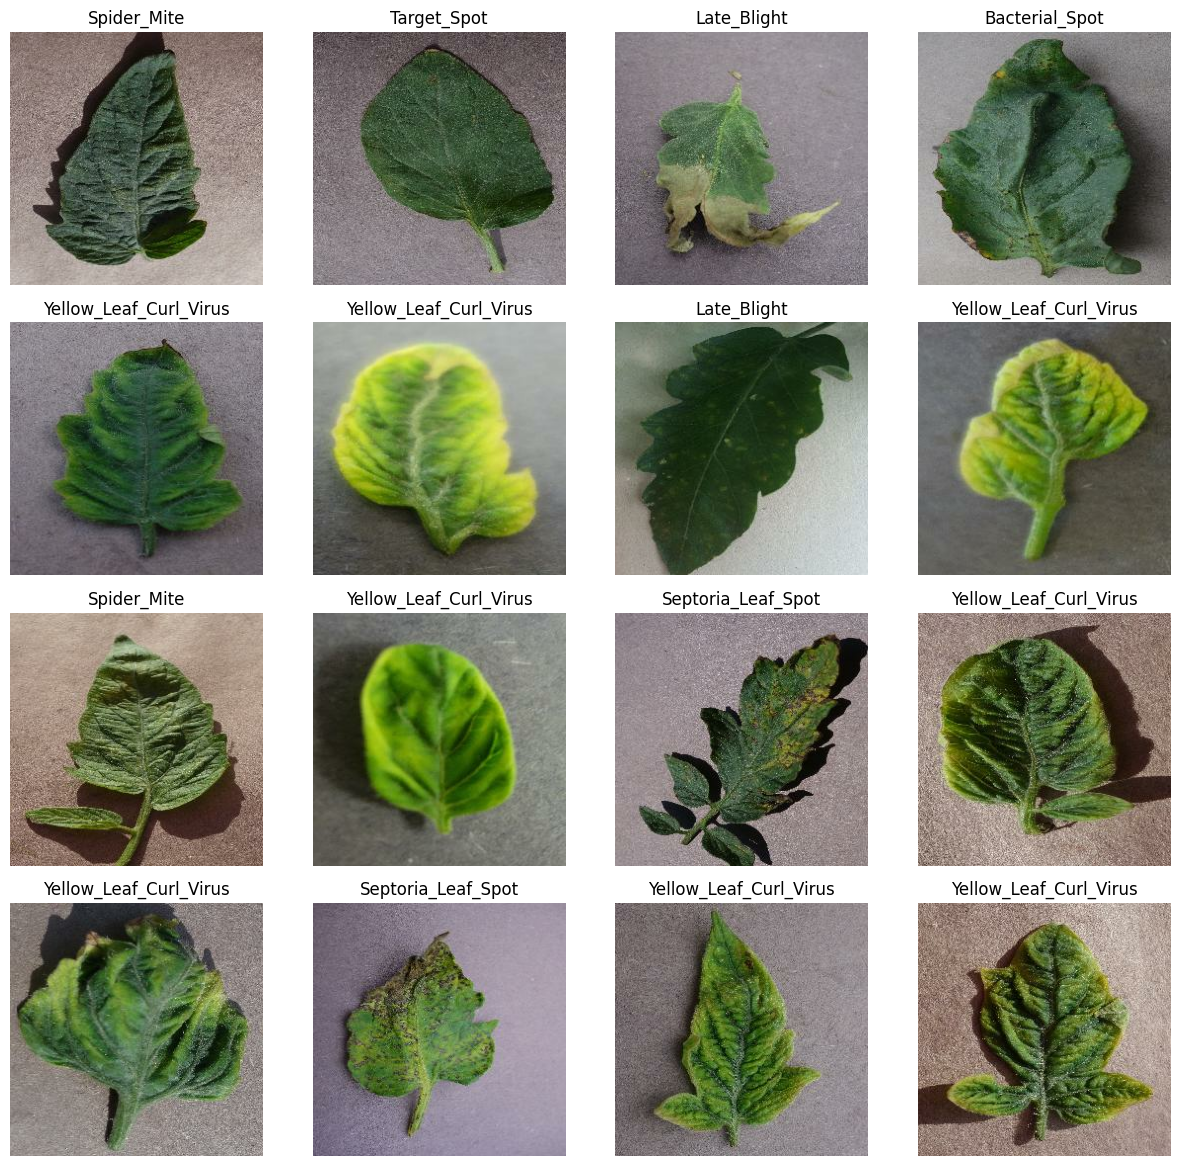

In [74]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Splitting Dataset into Training, Validation, and Testing

In [75]:
TRAIN_SIZE, VALIDATION_SIZE, TESTING_SIZE = 0.6, 0.2, 0.2

In [76]:
train_batch = int(len(dataset) * TRAIN_SIZE)
train_ds = dataset.take(train_batch)

In [77]:
val_batch = int(len(dataset) * VALIDATION_SIZE)
validation_ds = dataset.skip(train_batch).take(val_batch)

In [78]:
test_batch = int(len(dataset) * TESTING_SIZE)
test_ds = dataset.skip(train_batch + val_batch).take(test_batch)

# Building Model

## Resizing and Normalization Layer

In [79]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [80]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [81]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We employ a Convolutional Neural Network (CNN) integrated with a Softmax activation in the output layer. Additionally, our architecture includes foundational layers for resizing, normalization, and Data Augmentation, enhancing overall performance and robustness.

In [82]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [83]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (64, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (64, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (64, 60, 60, 64)         

We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [84]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Creating a checkpoint to save the model with the best score.

In [85]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.h5')
]

In [86]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = validation_ds,
    verbose = 1,
    epochs = EPOCHS,
    callbacks = callback
)

Epoch 1/50
150/150 [==============================] - 117s 759ms/step - loss: 1.7997 - accuracy: 0.3597 - val_loss: 1.3143 - val_accuracy: 0.5394
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 116s 774ms/step - loss: 1.1807 - accuracy: 0.5933 - val_loss: 0.9871 - val_accuracy: 0.6581
Epoch 3/50
150/150 [==============================] - 114s 761ms/step - loss: 0.9104 - accuracy: 0.6791 - val_loss: 0.9473 - val_accuracy: 0.6653
Epoch 4/50
150/150 [==============================] - 117s 780ms/step - loss: 0.7262 - accuracy: 0.7451 - val_loss: 1.1923 - val_accuracy: 0.6619
Epoch 5/50
150/150 [==============================] - 113s 754ms/step - loss: 0.5965 - accuracy: 0.7865 - val_loss: 0.6856 - val_accuracy: 0.7522
Epoch 6/50
150/150 [==============================] - 125s 830ms/step - loss: 0.5312 - accuracy: 0.8143 - val_loss: 0.8638 - val_accuracy: 0.7091
Epoch 7/50
150/150 [==============================] - 125s 832ms/step - loss: 0.4738 - accuracy: 0.8332 - val_loss: 0.4955 - val_accuracy: 0.8322
Epoch 8/50
150/150 [==============================] - 126s 839ms/step - loss: 0.4256 - accuracy: 0.8514 - val_loss: 0.6008 - val_accura

## Loading Model

In [87]:
model = load_model('model.h5')

## Evaluation

In [88]:
score = model.evaluate(test_ds)
score

50/50 [==============================] - 15s 63ms/step - loss: 0.2372 - accuracy: 0.9219


[0.23715436458587646, 0.921875]

# Plotting the Accuracy and Loss Curves

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

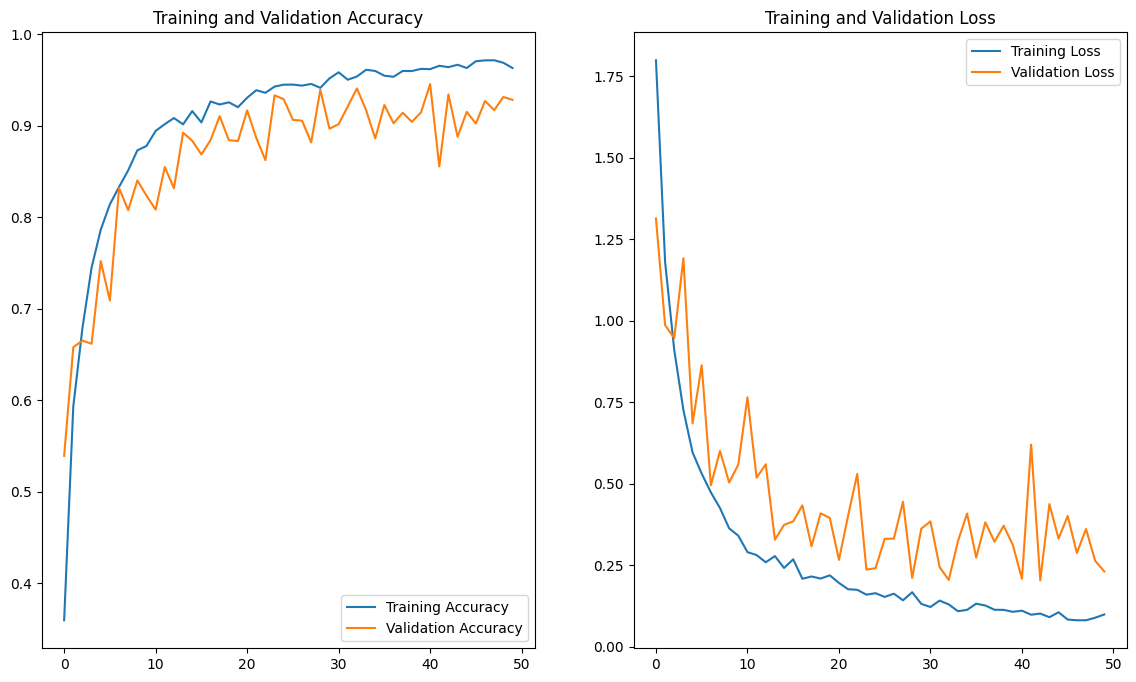

In [90]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Classification on Sample Images



## Interface Function

In [91]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Interface on Sample Images

1/1 [==============================] - 0s 21ms/step


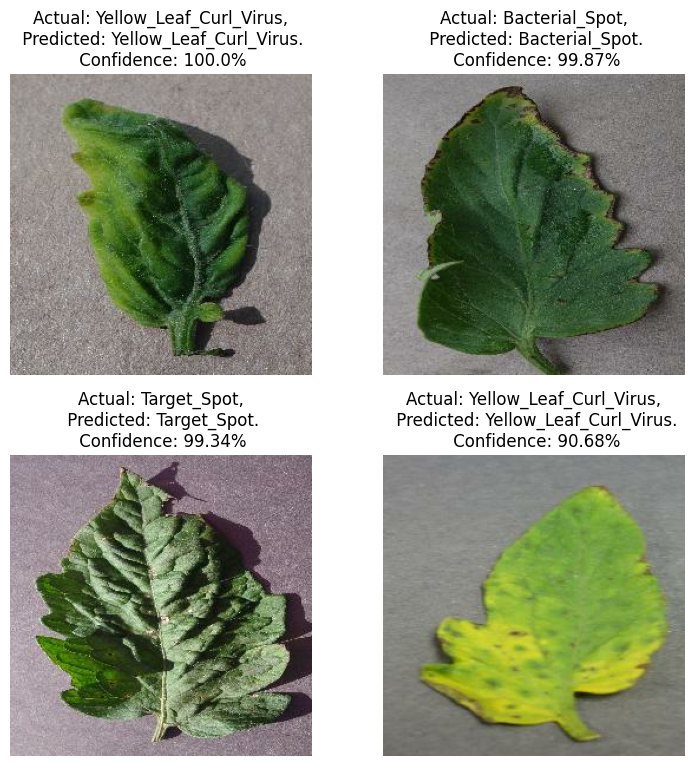

In [92]:
plt.figure(figsize=(8, 8))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.tight_layout()
        plt.axis("off")